# Deep Learning Lab part 1 Machine Learning, ANN, CNN

## Brief
Your main task in this lab is to make a network that can categorise bloodcells from the  [Human White Blood Cells (BBBC045v1)](https://bbbc.broadinstitute.org/BBBC045) dataset from the Broad Bioimage Benchmark Collection [Ljosa et al., Nature Methods, 2012]. 

First you will get some networks to try, and then some new techniques that you will apply to try and improve this network.  

*Note: It's not always easy to know from the start what will work, a lot of developing neural networks can feel like qualified guess work. **Qualified** being the key word.*

Also take this opportunity to try to understand the code, you may be able to reuse some of it for your assignment in Deep Learning. There will be questions throughout to give you things to consider, but **no hand in is required**. 

Stop the kernel of your other notebooks while you run this one. 

### Story (no instructions here)
You are working at BestEverLifeScienceCompany, or BELSC, and your boss was recently handed some blood cell data. The amount of blood cells over all, of each type, and the ratio in between are important health markers. (see [Human White Blood Cells (BBBC045v1)](https://bbbc.broadinstitute.org/BBBC045)) It's naturally very time consuming to go through them manually so your boss wants you to present atleast 3 different AI methods, preferably with an above 85% accuracy (1) , and for you to explain what each method does at the meeting on Monday morning at 8. 

You have a great weekend trip planned, and loads of things to do, so you really only have 2 hours to get as much as possible done. If you're lucky your boss will get stuck in a meeting with their boss again and you'll be able to present at an "impromptu" lunch meeting as have been the pattern for the last 4 weeks. (2)

* (1) Which you *do not* have to achieve in this lab
* (2) I.e. get as far as you can, if you don't finish in 2 hours it's ok to work with this part during the  next session

If you do finish part 1 and still have a lot of time left, feel free to start part2. 

#### Credit
A lot of the code below is inspired by https://www.tensorflow.org/guide/keras/functional/,  and labs developed by Christophe Avenel at NBIS, the cnn_helper is from there, but adjusted by me. The lab is also partly built on Phil Harrison's lab for the pharmaceutical bioinformatics and sequence analysis course. I've also added my own parts of the code as well


The questions were designed and the tasks modified by Ebba Bergman for Big Data in Life Sciences

# Import

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import IPython
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from datetime import datetime
import cv2
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cnn_helper
import plot_helper

from IPython.display import display, HTML

In [ ]:
from importlib.machinery import SourceFileLoader
HOME_PATH = "/home/jovyan/"

cnn_helper = SourceFileLoader("cnn_helper", "cnn_helper.py").load_module()
plot_helper = SourceFileLoader("plot_helper","plot_helper.py").load_module()

In [ ]:
# Configure GPUs
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      print("Done setting memory_growth")
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except Exception as e:
    # Memory growth must be set before GPUs have been initialized
    print("If you get this , probably done already")
    # Catch the exception and display a custom HTML message with red text
    message = """There was some problems setting up the GPU,
                 it is probably best to restart kernel and clear
                 all outputs before starting over
              """
    display(HTML(f"<div style='color: red;'><strong>Warning:</strong>{message}</div>"))
    print(e)

# Paths

In [ ]:
current_directory = os.getcwd()
print(current_directory)

In [ ]:
base_directory = "" # add the full path before /Labs here, make sure to add a / at the end

In [ ]:
## Set up where to find our data
zipped_data = base_directory + "ZippedLabData/bloodcells_small.tar.gz"
data_directory = base_directory + "LabData/bloodcells_small/data/"
labels_path = base_directory + "LabData/bloodcells_small/labels.csv"

# Functions

Don't worry about the functions, they'll make more sense later. Just keep moving along.

In [ ]:
def start_time():
    print("Starting run at: " + str(datetime.now()))

def end_time():
    print("Run finished at: " + str(datetime.now()))
    
def get_image_data_flat_from_file(data_directory, image_paths):
    file_names = image_paths.values.flatten() # Assumes image_paths come in df[image_path_column_name] structure due to lab
    image_data = np.array([np.array(cv2.imread(data_directory + file_name)) for file_name in file_names])
    flattened_image_data = image_data.reshape(image_data.shape[0], -1)
    return flattened_image_data

# Exctract Data

In [ ]:
print(current_directory)

This will be done in a terminal, you can see all instructions here: https://www.cyberciti.biz/faq/howto-extract-tar-file-to-specific-directory-on-unixlinux/ 

But the **commands you need** are:

cd [the path to the bigData directory given above]

mkdir LabData

tar xf ZippedLabData/bloodcells_small.tar.gz -C LabData



**check that the files have been extracted into LabData/bloodcells_small/**

# Data

Let's load and then look at the labels and our data.

In [ ]:
df_labels = pd.read_csv(labels_path) 

<details>
<summary>
<font size="3" color="green">
<b>If the data isn't loading<code><font size="4">you get a big read square ending with "[Errno 2] No such file or directory: "</font></code></b>
</font>
</summary>

go back to your terminal, step into the bloodcells_small folder and execute this command:

chmod +rwx labels.csv 

You may need to restart the kernel for this notebook inorder for the notebook to know that the file is accessible.
</details>



<details>
<summary>
<font size="3" color="green">
<b>Data frames <code><font size="4">explanation</font></code></b>
</font>
</summary>

These cells allows text to be hidden. I'll write explanations here if you want them, but do try to think of the answer to questions first.

df: This is a dataframe, a way to look at data as tables.
Google "Python pandas dataframe" to get more information, or to find new commands as you need.
 Anything you can do with data frames you could do with loops and numpy, but it is sometimes easier to read and write code with dataframes and a lot of data analysts use them.

</details>


In [ ]:
df_labels.head()

In [ ]:
df_labels.shape

### Q: Look at the labels, which column do you think contains the true label?

To see how many different labels we have, assign the true_label_column the correct name, and run the cells

In [ ]:
true_label_column = ""

In [ ]:
df_labels[true_label_column].unique()

In [ ]:
df_labels[true_label_column].value_counts()

### Q: Which label has the smallest amount of datapoints?

## Look at a sample of the images

Let's look at the images - always a good start to the project.\
Here random images will be displayed, run this several time to see different images

The plotting functions are in plot_helper.py in this directory if you want to look at them.

In [ ]:
file_column = "" ## Enter the name of the file names column
plot_helper.show_random_images(data_directory, df_labels, file_column)

### Q: Can you see any difference between the classes? 
### Q: Do you think a human being able to see the difference between classes makes it an easier or more difficult problem for a neural network? Or does it not matter at all?

## Divide into training, validation and test set

### Q: Why do we need 3 sets? In other machine learning we usually use 2?

<details>
<summary>
<font size="3" color="green">
<b>Data sets <code><font size="4">explanation  </font></code></b>
</font>
</summary>

So what we always try to do is make a model and then evaluate it on data it has never seen before. 
This is the first split, training vs test, which you've probably seen a lot before.

In Deep Learning we *can* use that split, but it is much, much more common to do a training, validation, test split.

The extra validation set let's us "test" the model as we train it. Based on that we can then see trends in how the model learns, and use that to improve the model as we train or at end of training. Early stopping is one such example where the model that performed best on the validation set, which the model has not been trained on, is chosen. It is then tested with the "test" set. 

### Q:Why can't we just use the test set to stop training?
</details>

In [ ]:
## Next, let's divide the filtered rows into a train, validation and a test set. 
class_column_header = "Class"
df_labels_to_use = df_labels.copy() #We're copying the df_labels so that you can look at the original again later if you want

test_set_fraction = 0.1
validation_set_fraction = 0.2

In [ ]:
df_test = df_labels_to_use.groupby(class_column_header).sample(frac = test_set_fraction)
df_to_use = pd.concat([df_labels_to_use, df_test, df_test]).drop_duplicates(keep=False) # This line finds the intersection between df_filtered and df_test and df_test and dropps anything that belongs to two of those, so we are left with df_train. Using only df_test once should be fine, but better safe than sorry
df_validation = df_labels_to_use.groupby(class_column_header).sample(frac = validation_set_fraction)
df_train = pd.concat([df_labels_to_use, df_validation, df_validation]).drop_duplicates(keep=False) 

In [ ]:
print(df_test.head())

### Question: How many bloodcells of type T is there in the test dataset?

In [ ]:
## Write your code here

# Models

# Logistic Regression

**Assignment**  Make a traditional machine learning model to compare to the ANN.

Read more about Logistic regression here: https://www.javatpoint.com/logistic-regression-in-machine-learning
#### Q: Can you see a simmilarity between Logistic Regression and any part of the ANN? Think back to the lecture.

In [ ]:
df_lr_test = pd.concat([df_validation, df_test])
lr_x_test = get_image_data_flat_from_file(data_directory, df_lr_test[file_column])
lr_x_test.shape

In [ ]:
lr_y_test = df_lr_test[true_label_column]
lr_y_test.shape

In [ ]:
df_train.shape

In [ ]:
lr_x_train = get_image_data_flat_from_file(data_directory, df_train[file_column])
lr_x_train.shape

In [ ]:
lr_y_train = df_train[true_label_column]
lr_y_train.shape

In [ ]:
# Normalise to unit variance
scaler = StandardScaler().fit(lr_x_train)
lr_x_train = scaler.transform(lr_x_train)
lr_x_test = scaler.transform(lr_x_test)

In [ ]:
start_time()
LR_model  = LogisticRegression(multi_class = "multinomial",max_iter = 20)
LR_model.fit(lr_x_train, lr_y_train)
end_time()

<details>
<summary>
<font size="3" color="green">
<b>Help <code><font size="4"> If Logistic Regression takes a long time  </font></code></b>
</font>
</summary>
This is not a great dataset for logistic regression (LR). Can you figure out why this is the chosen model for this task to compare to NN anyways? Hint: it's not because it's bad.

If you figured that out and the LR still isn't done, keep reading ahead and see ifyou understand the next tasks. The LR took 4.5 minutes for me to run with 100 iterations. Then I tried 200 iterations and it took 3.5 minutes. Timeestimations can be very inexact, especially as we run on kernels that also have other jobs qued up   

Here we've set it to 20, hopefully that will be quicker. 
</details>

<details>
<summary>
<font size="3" color="green">
<b>Help <code><font size="4"> If a red box with warnings appears  </font></code></b>
</font>
</summary>
 If your model doesn't converge here, that's to be expected. We'd probably need to finetune this model, or this might not be a problem suitable for this model.  But we're not going to focus on that now, since we are focusing on Neural Networks. A fair amount of the fin tuning we do to neural networks we can apply to all machine learning, more about that in lecture 2.
 
 Let's now see how well this method did out of the box.
</details>

In [ ]:
LR_pred = LR_model.predict(lr_x_test)
LR_score = LR_model.score(lr_x_test, lr_y_test)
print('Logistic Regression: accuracy = ' + str(np.round(LR_score, 3)))

In [ ]:
class_labels = df_train[true_label_column].unique()
cm = confusion_matrix(lr_y_test, LR_pred, labels  = class_labels, normalize = "true")
plot_helper.plot_confusion_matrix(cm, classes = class_labels, title = "LR Confustion Matrix" )


#### Q: Which two classes were most often confused with each other?


## A simple Multi Layer Perceptron (MLP)

You get the first MLP written out, in the next sections you'll need to write your own models.

### Model Architecture

**Concep**
The architecture of a network is basically the blue print of the network. That is the combination of how many nodes in how many layers. The architecture is a key part of the desing of a neural network, and one thing to change if you want to get better results.

But we have to start somewhere

In [ ]:
## Set up the model architecture
inputs = keras.Input(shape= (32,32,1))
x = layers.Flatten()(inputs)
x = layers.Dense(7, activation="relu")(x)
outputs = layers.Dense(5, activation="softmax")(x)

In [ ]:
## Define the model as a keras model
ann_model = keras.Model(inputs=inputs, outputs=outputs, name="ann_model")

### Q: Why is the input shape the way it is?

### Q: How many layers do we have?


<details>
<summary>
<font size="3" color="green">
<b>Layers <code><font size="4"> theory vs programming  </font></code></b>
</font>
</summary>

Usually we only count layers of neurons when we talk about Neural Networks. 

So we do not count the input layer as a proper layer as it does not contain any neurons nor parameters nor does anything to the input (it basically *is* the input).

In this case we also have a *Flatten* layer, which takes a 2D structure and makes a 1D structure as we talked about in the lecture. This also isn't actualy a layer of neurons and so we won't count that either. 

I would say we have 2 layers.One output layer, and one hidden layer.

Others might say 3 or even 4, but they're increasingly wrong with the numbers of layers they add. 

</details>



#### Architecture Summary 

In [ ]:
ann_model.summary()

### Question: How do you get the number of parameters for the output layer? 

**Hint:**  Some people find it helpful to draw the network using pen and paper

### Training

Now that we have our model, all of our parameters are randomized. To make the model better than random we need to train the model. 

#### Q: What would be the "best" accuracy you could expect from the network without it having learned anything?

<details>
<summary>
<font size="3" color="green">
<b>Ebba's thoughts<code><font size="4">first accuracy</font></code></b>
</font>
</summary>
It is almost impossible to know the accuracy without having done similar things with similar images before, so I would not expect to know at this point.

    
What I would do is calculate what would signify as a random accuracy or the best accuracy possible if the network only guesses at 1 class for all of the images. For 5 classes inuitively it's 20% accuracy, but it will ofcourse depend on the distribution of the classes. If we have 3 classes A, B, and C, and class A has 100 images, B 50 images, and C 50 images, then I'd be causious of a 50% accuracy as the network could simply be guessing class A for every result. 
</details>

For more information on the ImageDataGenerator see: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [ ]:
## Set up generators that specify how the images are loaded, how many at a time (batch size),
## that the images should be shuffled should be shuffled etc.
batch_size = 8

image_shape = (32,32)
filename_column = 'Filenames'
true_label_column = "Class"
# create a data generator

## Note: we tend to get better results if the values of the pixels are between 0 and 1, 
#so we need a rescale of 1/255 since the highest possible pixel value for these images are 255
train_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, samplewise_center=True, samplewise_std_normalization=True)
valid_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, samplewise_center=True, samplewise_std_normalization=True)
test_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, samplewise_center=True, samplewise_std_normalization=True)

train_generator = train_data_generator.flow_from_dataframe(
    df_train, directory=data_directory, x_col=filename_column, y_col=true_label_column,
    weight_col=None, class_mode='categorical', batch_size=batch_size, target_size = image_shape,  color_mode='grayscale' ,shuffle=True,
)

valid_generator = valid_data_generator.flow_from_dataframe(
    df_validation, directory=data_directory, x_col=filename_column, y_col=true_label_column,
    weight_col=None, class_mode='categorical', batch_size=batch_size, target_size = image_shape,  color_mode='grayscale' , shuffle=False,
)


test_generator = test_data_generator.flow_from_dataframe(
    df_test, directory=data_directory, x_col=filename_column, y_col=true_label_column,
    weight_col=None,class_mode='categorical', batch_size=batch_size, target_size = image_shape,  color_mode='grayscale' , shuffle=False,
)


train_steps = train_generator.n//train_generator.batch_size if train_generator.n >= train_generator.batch_size else 1
validation_steps = valid_generator.n//valid_generator.batch_size if valid_generator.n >= valid_generator.batch_size else 1



In [ ]:
## Compile model
## Don't worry about the details here yet
ann_model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
## Actually train model
## Don't worry about the details here yet

start_time()
epochs = 5
history = ann_model.fit(x=train_generator,
                    steps_per_epoch= train_steps,
                    validation_data= valid_generator,
                    validation_steps= validation_steps,
                    epochs= epochs
        )
end_time()

<details>
<summary>
<font size="3" color="green">
<b>Help <code><font size="4"> If a red box with warnings appears  </font></code></b>
</font>
</summary>
 This is a deprecation issue, and yes I (Ebba) should update the code before it breaks, but it's not broken yet and there were more important things to get done for this course. It runs, it's all fine.   
    
 In general: unless existing code gets an Error, don't worry about it. If your code gets a new kind of warning, double check that it's ok before you proceed.
</details>

In [ ]:
## Plot results
results = plot_helper.plot_history(history, "ANN")

### Q: How did you do? 
### Q: What do the curves tell you? 

In [ ]:
# plot confusion matrix
cnn_helper.plot_confusion_matrix_from_generator(ann_model, valid_generator)



### Q: Which class was easiest to predict? Which was the most difficult to predict?

So now that we have made our first simple model, let's see how it compares to a linear regression


### Q: Which worked better, your small ANN or the Linear regression?

### A longer LR training session

This is a Logistic Regression that ran for 200 iterations (i.e. 10 times longer than yours). 
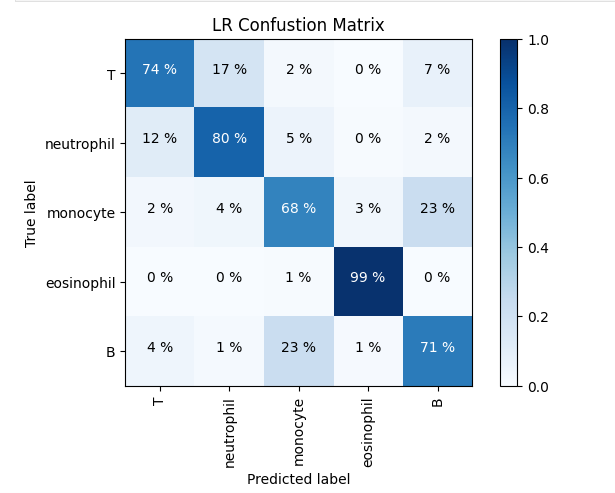 

### Q: How does this result compare to your small ANN?

# Visualise a layer

For fun, let's look at the weights in the first dense layer. Visualising your data can be a good way to see what is going wrong as well as where the difficulties might be.

**As you saw in the lecture the MLP works with vectors (rows of numbers), so let's visualise the weights as that.** The x-axis will be the position of the weight (i.e. w1,w2 etc.) The color will be the size of the weight


In [ ]:
weights, bias = ann_model.layers[2].get_weights()


In [ ]:
weights.shape


In [ ]:
plot_helper.plot_layer_weights(weights)

### Q: Do you think that the network is doing a good job recognizing the blood cells based on this visualisation?

Now, we do know that we're actually woring with 2D data, so let's see if it will make more sense to our human eyes if we visualise it as such.

In [ ]:
plot_helper.plot_layer_weights(weights, visualize_in_2d= True)

Here the higher values are represented by yelow, lower by dark blue. This is a heatmap visualisation. 
### Q: Do you think that the network is doing a good job recognizing the blood cells based on this visualisation?

So now we have a model. It does something, we can see that it recognises different type of blood cells. How can we make it even better? In many, many ways. But let's start with how we can change the model we have set up.

# Epochs and batches

Good explanation of epochs and batches: https://machine-learning.paperspace.com/wiki/epoch

But basically:

A **batch** is the training examples that are forward propageted before we backpropagate. This lets us get overall trends in how we should adjust our parameters (weights and biases). If we back propagated after every single forward propagation it would both take longer to train the network and make the model fit more to individual data points instead of overall trends. 

**Batch size** is how many examples (images) that we have in a batch

**Epoch**: When all the training data has been forward propagated and back propagated we have trained for one epoch. So if we have 10 batches then we have run 2 epochs after 20 batches. So more epochs == more training



Take another look at your ANN results above. They might look something like these curves below. See how they are continuing to improve until the end? This means that if we trained them for longer we'd probably get even better results. 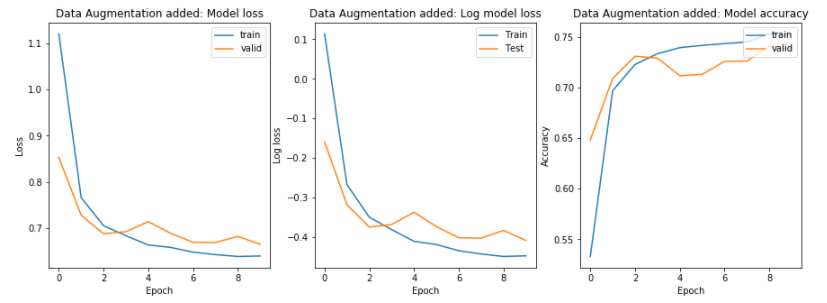

**Assignment** Try training your ANN for another 10 epochs.

In [ ]:
## Keep training the model

epochs = 10
start_time()
history = ann_model.fit(x=train_generator,
                    steps_per_epoch= train_steps,
                    validation_data= valid_generator,
                    validation_steps= validation_steps,
                    epochs= epochs
        )
end_time()

In [ ]:
## Plot results
plot_helper.plot_history(history, "ANN, 15 epochs, last 10 epochs shown")

In [ ]:
# plot confusion matrix
cnn_helper.plot_confusion_matrix_from_generator(ann_model, valid_generator)

#### Q: Did your results improve?

**Assignment** Train your model for another 10 epochs You can read ahead while you wait for this to run

In [ ]:
## Actually train model
## Don't worry about the details here yet

epochs = 10
start_time()
history = ann_model.fit(x=train_generator,
                    steps_per_epoch= train_steps,
                    validation_data= valid_generator,
                    validation_steps= validation_steps,
                    epochs= epochs
        )
end_time()

In [ ]:
## Plot results
plot_helper.plot_history(history, "ANN, 25 epochs, last 10 shown")

In [ ]:
# plot confusion matrix
cnn_helper.plot_confusion_matrix_from_generator(ann_model, valid_generator)

#### Q: What happened to your results now?

**Note** Waiting for things to run is unproductive during a lab, so  <span style="color:red"> **train with 5 epochs for the remainder of the lab** </span> 

# Expanding the model

## Make a new, longer ANN

**Assignment** Base your ANN on the ANN above. Add atleast another dense layer, making it so that the new layer after the input layer has atleast 10 nodes. You may add even more, and wider, layers if you like. Keep the last layer before the output layer as a 7 node layer.

### Q: How many parameters will your layer have?
### Q: How will your new layers affect how many parameters the output layer has? Why?

### Q: How did you do? What do the curves tell you? 


In [ ]:
# plot confusion matrix
cnn_helper.plot_confusion_matrix_from_generator(ann_model, valid_generator)

### Q: Which class was easiest to predict? Which was the most difficult to predict?


# CNN

Let's try a simple CNN next. 
### Q: Do you think a CNN will have better results than an MLP?

### Q: What are the biggest differences between how an MLP and a CNN treats the data?

In [ ]:
## Set up the model architecture
# See https://www.tensorflow.org/guide/keras/functional/ if you want to see the documentation

cnn_inputs = keras.Input(shape=(32,32,1))
x = layers.Conv2D(1, kernel_size=(3, 3), strides=1,padding='same')(cnn_inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
cnn_outputs = layers.Dense(5, activation='softmax')(x)

### Some basic CNN concepts
 <span style="color:red"> You may be asked questions on the exam that assumes you know and can provide the definition of the words in bold below or any other new information introduced during the labs. </span> 

Conv2D is a convolution in 2 dimensions. As you saw in the lecture during a convolution we move a filter across the image, doing some basic math on all the numbers the filter touches and putting it into a new square (pixel) in our new "image". This resulting image is called a **filter map**

A **kernel** is the same as a filter in this context (Tip: stackexchange usually gives quick answers if you're wondering about something, but should never be used as a reference in a scientific context
https://stats.stackexchange.com/questions/154798/difference-between-kernel-and-filter-in-cnn)

The **kernel size** is therefore the same as the filter size, here 3x3.  

**strides** is how many steps or pixels the filter will move at a time. In the stack exchange above you can see a gif of a filter moving 1 pixel. Filters will move left to right, up to down, same as your eyes reading this text. 

**padding** notice how the pixel in the top left corner will only be used once for calculations in the example in the lecture (and the gif above)? This means that corners will have less input on the final result. To change this we can add rows of numbers around the original image/filter map so that each value in the image gets used the same number of times. 

Also note that if we do not padd the output of a convolution is always smaller than the input. By using padding = Same the colvolution output size will be the same as the input size.  (https://www.tensorflow.org/api_docs/python/tf/pad) 

**Pooling** If we keep having the same size output as input but generating more filter map outputs than we have inputs (why do we do this?) we will quickly get a large amount of data, i.e. a lot of math to do which means training will take longer and require more data. In these filtermaps there might be a lot of superflous pixels that do not add more information. So to concentrate the information we use pooling. This is another matrix that will move across the filtermap but the stride will always be the same as the matrix so no pixel is touched twice.
(see the first diagram here https://indiantechwarrior.com/how-to-work-with-cnn-max-pooling-layers-in-tensorflow/) 

**Max pooling** will take the biggest number and put it into the new filtermap.
**Average pooling** will take the average of the numbers and put it into a new filtermap.

https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D 


### Q: Why has the .Flatten()(x) layer moved in the CNN compared to the ANN?

In [ ]:
## Define the model as a keras model
cnn_model = keras.Model(inputs=cnn_inputs, outputs=cnn_outputs, name="cnn_Model_1")

In [ ]:
## We'll use the same generators as above here, so no need to redefine them
## compile model

cnn_model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics = ['accuracy'])
cnn_model.summary()

In [ ]:
## Actually train model
epochs = 5
history = cnn_model.fit(x=train_generator,
                    steps_per_epoch= train_steps,
                    validation_data= valid_generator,
                    validation_steps= validation_steps,
                    epochs= epochs
        )

In [ ]:
## Plot results
plot_helper.plot_history(history, "CNN")

### Question: How is your model fiting? 

In [ ]:
# plot confusion matrix
cnn_helper.plot_confusion_matrix_from_generator(cnn_model, valid_generator)

### Q: How many parameters did you have in the ANN vs in the CNN?

### Q: What networked performed best for you? Did the results differ for any of the classes between the ANN and CNN?



<details>
<summary>
<font size="3" color="green">
<b>Expand this after trying to answer the question above<code><font size="4">ANN vs CNN</font></code></b>
</font>
</summary>
Likely the MLP outperformed the CNN. Usually we expect a convolutional neural network to perform better than a MLP when working with images. This is because images are *atleast* 2D structures, and information can be in many places in the images. 

Why then did the ANN outperform the CNN in this case? Think about the data, does the placement of the information vary a lot in the images?    
    
</details>

# Expanding the models

## Deeper models


As you already saw with the ANN, sometimes a deeper model and/or a more complex model, can be helpful. Try adding some more convolution layers and pooling layers to the model. Try changing the filter sizes, and the number of filters as well.

More information about the convolutional layer can be found here: https://keras.io/api/layers/convolution_layers/convolution2d/, maxpooling here: https://keras.io/api/layers/pooling_layers/max_pooling2d/, and a different kind of way of making models can be found here: https://www.tensorflow.org/tutorials/images/cnn  and here https://www.tensorflow.org/tutorials/quickstart/advanced

## Make your model below

## Test the model

In [ ]:
cnn_model.evaluate(test_generator)

In [ ]:
cnn_helper.plot_confusion_matrix_from_generator(cnn_model, test_generator)

## If you have a lot of time left in the lab (15 minutes or more): Move on to the next part


## Hints about Jupyter notebooks

#### HINT: You can comment out a whole cell by selecting all and then do ctr + / or cmnd + / 
#### You can then add another cell with the + button next to the save button at the top of this notebook's tool bar.
#### You can of course also keep adding cells and copying all the relevant code, making and saving new models. Whatever is easiest for you is best here.